In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import re

In [228]:
Boundary = gpd.read_file('../data/PA/City_Plan_Boundary.geojson')
Census_group = gpd.read_file('../data/PA/Census_Block_Groups_2010.geojson')

288

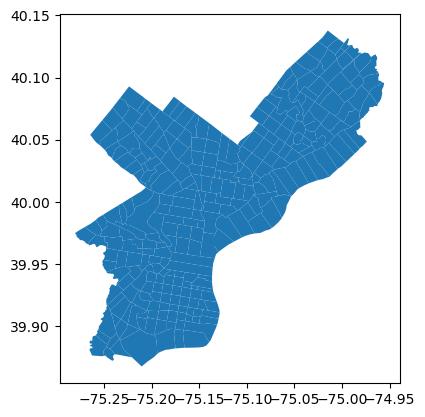

In [225]:
Boundary.plot()
len(Boundary)

1336

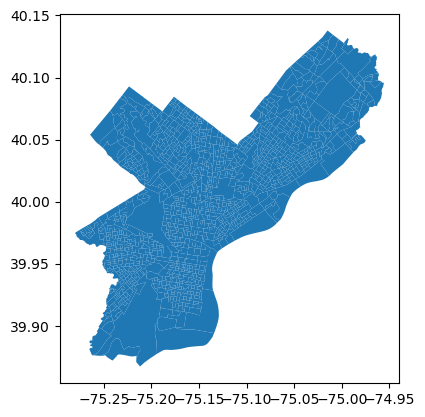

In [229]:
Census_group.plot()
len(Census_group)

17315

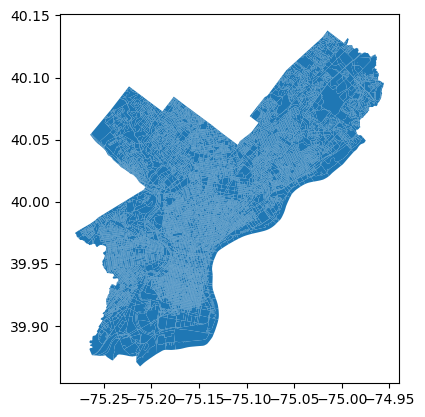

In [18]:
Census = gpd.read_file('../data/PA/Census_Blocks_2000.geojson')
Census.plot()
len(Census)

## Data Cleaning

In [57]:
def merge_demand(file, year, quarter):
    trip = pd.read_csv(file)
    start_count = trip.groupby('Start_OBJECTID').count()['trip_id']
    end_count = trip.groupby('End_OBJECTID').count()['trip_id']
    start_count = pd.DataFrame(start_count)
    end_count = pd.DataFrame(end_count)
    
    # 修改列名
    start_count.columns = [f'{year}_q{quarter}_start_count']
    end_count.columns = [f'{year}_q{quarter}_end_count']
    
    # merge两个dataframes到demand，demand已经存在，保留不同的列
    global demand
    demand = pd.merge(demand, start_count, left_index=True, right_index=True)
    demand = pd.merge(demand, end_count, left_index=True, right_index=True)

In [112]:
demand

,2019_q1_start_count,2019_q1_end_count,2019_q2_start_count,2019_q2_end_count,2019_q3_start_count,2019_q3_end_count,2019_q4_start_count,2019_q4_end_count,2020_q1_start_count,2020_q1_end_count,...,2021_q4_end_count,2022_q1_start_count,2022_q1_end_count,2022_q2_start_count,2022_q2_end_count,2022_q3_start_count,2022_q3_end_count,2022_q4_start_count,2022_q4_end_count,demand_index
123,51,47,606,546,689,688,195,179,199,168,...,434,130,124,290,291,275,257,152,145,123
125,122,126,992,987,1029,1021,358,349,216,241,...,77,59,50,173,159,261,320,193,209,125
129,396,460,1053,1170,1766,1818,855,865,593,650,...,2202,897,926,2109,2265,2127,2338,1287,1462,129
131,1499,1462,5443,5343,4911,4886,1752,1795,1473,1510,...,3060,1012,957,3930,3789,3248,3122,1729,1636,131
133,218,172,961,890,741,676,209,149,195,139,...,288,81,88,325,303,636,586,477,446,133
135,822,752,1290,1125,2330,2217,1660,1511,1285,1190,...,3337,1507,1459,2792,2723,2710,2603,2011,1944,135
136,412,345,653,523,796,717,510,474,360,316,...,1079,384,358,880,825,1035,970,754,730,136
137,1352,1136,3247,2983,3682,3447,1942,1800,1692,1472,...,3113,1324,1256,2403,2260,2996,2816,1241,1114,137
139,79,67,236,212,471,469,192,169,83,89,...,254,95,84,221,216,396,394,162,189,139
141,1769,1299,3284,2589,5070,4288,2545,2034,1980,1502,...,5158,2653,2215,4472,3961,5044,4455,3621,3023,141


In [111]:
# make the demand index a new column as type int64
demand['demand_index'] = demand.index.astype('int64')

In [142]:
demand.sum()

2019_q1_start_count                                                96593
2019_q1_end_count                                                  95062
2019_q2_start_count                                               205698
2019_q2_end_count                                                 203094
2019_q3_start_count                                               273072
2019_q3_end_count                                                 269906
2019_q4_start_count                                               165161
2019_q4_end_count                                                 162459
2020_q1_start_count                                               117564
2020_q1_end_count                                                 115385
2020_q2_start_count                                               185244
2020_q2_end_count                                                 182070
2020_q3_start_count                                               268408
2020_q3_end_count                                  

In [203]:
demand.to_csv('../data/PA/share_bike/demand2019to2022.csv')

## show the demand on the map

In [7]:
# count the number of trips in each tractce
trips = pd.read_csv("../data/PA/share_bike/indego-trips-2019-q4_label.csv")
start_count = trips.groupby('Start_OBJECTID').count()['trip_id']
end_count = trips.groupby('End_OBJECTID').count()['trip_id']

In [8]:
start_count = pd.DataFrame(start_count)
# rename the column
start_count.columns = ['start_count']
start_count.reset_index(level=0,inplace=True)

In [9]:
end_count = pd.DataFrame(end_count)
# rename the column
end_count.columns = ['end_count']
end_count.reset_index(level=0,inplace=True)
end_count['End_OBJECTID'] = end_count['End_OBJECTID'].astype('int64')
end_count.head()

,End_OBJECTID,end_count
0,123,179
1,125,349
2,129,865
3,131,1795
4,133,149


In [10]:
End_demand = Boundary.merge(end_count, left_on='OBJECTID', right_on='End_OBJECTID', how='left')

In [11]:
# make the index of start_count a column
# start_count.reset_index(level=0, inplace=True)
# make the Start_OBJECTID as the same type as the OBJECTID in Boundary
start_count['Start_OBJECTID'] = start_count['Start_OBJECTID'].astype('int64')
start_count.head()

,Start_OBJECTID,start_count
0,123,195
1,125,358
2,129,855
3,131,1752
4,133,209


In [12]:
Start_demand = Boundary.merge(start_count, left_on='OBJECTID', right_on='Start_OBJECTID', how='left')

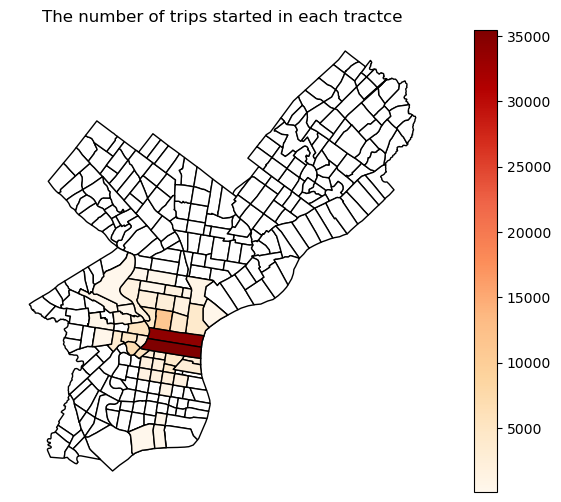

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 6))
Boundary.plot(ax=ax, color='white', edgecolor='black')
Start_demand.plot(ax=ax, column='start_count', cmap='OrRd', edgecolor='black', legend=True)
ax.set_title('The number of trips started in each tractce')
ax.set_axis_off()
plt.show()

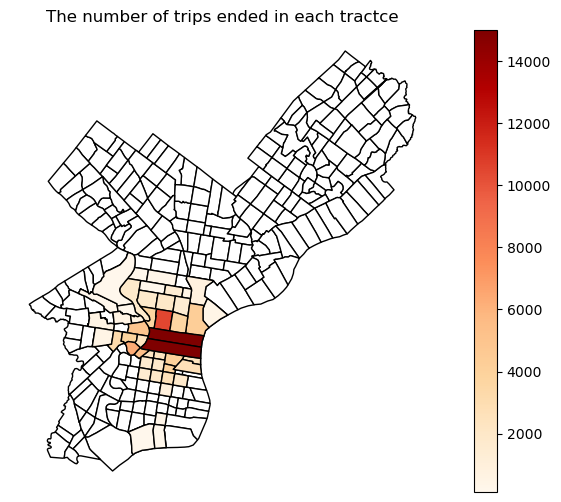

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 6))
Boundary.plot(ax=ax, color='white', edgecolor='black')
End_demand.plot(ax=ax, column='end_count', cmap='OrRd', edgecolor='black', legend=True, vmax=15000)
ax.set_title('The number of trips ended in each tractce')
ax.set_axis_off()
plt.show()

## show the distribution of the number of business in each tractce

In [14]:
business = pd.read_csv('../data/PA/business_Phi_label.csv')
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,OBJECTID
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107.0,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",272.0
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106.0,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",272.0
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147.0,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",180.0
3,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147.0,39.939825,-75.157447,4.0,65,0,"{'Smoking': ""u'no'"", 'NoiseLevel': ""u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",180.0
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,4105 Main St,Philadelphia,PA,19127.0,40.022466,-75.218314,3.0,41,0,"{'RestaurantsReservations': 'False', 'Caters':...","Pizza, Restaurants, Salad, Soup","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-1...",100.0


In [15]:
business_count = business.groupby('OBJECTID').count()['business_id']
business_count = pd.DataFrame(business_count)
# rename the column
business_count.columns = ['business_count']
business_count.reset_index(level=0,inplace=True)
business_count['OBJECTID'] = business_count['OBJECTID'].astype('int64')
business_count.head()

,OBJECTID,business_count
0,1,12
1,2,14
2,3,7
3,4,7
4,5,35


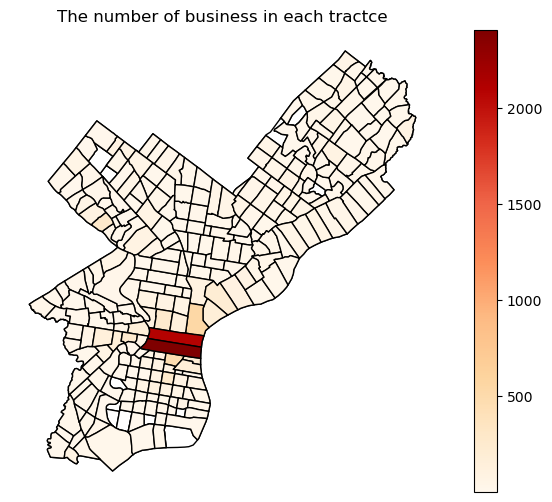

In [16]:
Business_distribution = Boundary.merge(business_count, left_on='OBJECTID', right_on='OBJECTID', how='left')
fig, ax = plt.subplots(1, figsize=(10, 6))
Boundary.plot(ax=ax, color='white', edgecolor='black')
Business_distribution.plot(ax=ax, column='business_count', cmap='OrRd', edgecolor='black', legend=True)
ax.set_title('The number of business in each tractce')
ax.set_axis_off()
plt.show()

## show the embeddings

In [97]:
embeddings = pd.read_csv('../data/PA/review_Phi_embedding.csv')

In [98]:
def str2vec(embedding_string):
    embedding_string = embedding_string.replace('[', '').replace(']', '')  # Remove square brackets
    embedding_string = embedding_string.replace('\n', '')  # Remove line break
    embedding_list = embedding_string.split()  # Split string by space
    embedding_vector = np.array(embedding_list, dtype=np.float32)  # Convert list to numpy array of floats
    return embedding_vector

In [99]:
embeddings['review_embedding'] = embeddings['review_embedding'].apply(str2vec)

In [100]:
embeddings.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_embedding
0,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5.0,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,"[-0.0783931, -0.0473093, 0.084804595, 0.041779..."
1,4KpIldEM-tdnrJLqYzRfZQ,Z5j9Xw_G0c7M2b1-iS67wg,HTqXI5S2XcSlh_ylx9sE6g,5.0,1,1,1,I've only had the cannolis here but they are a...,2018-03-23 14:35:33,"[-0.023478506, -0.043423448, -0.008545862, -0...."
2,gImS1dtA_TixEouDfp2o4g,xE7AXFF9wVaN6id6OCtH3Q,D5V0Fawd6ODVgqCY8xngsw,4.0,1,0,2,I have been to a number of dog friendly hotels...,2017-01-14 21:05:04,"[0.060713865, -4.573093e-05, 0.059097886, 0.10..."
3,dUkUiVjwb9xCF1kMqjT6nA,EDPlya2Sfu0teqreA3rlZw,FnEkr6LzjuGsg93Z7fkl7Q,2.0,0,0,0,"Before I share the main issue, I want to share...",2017-12-29 20:44:06,"[-0.018949073, 0.019054951, 0.025078008, 0.030..."
4,g7MfpJGKQUGowCvIcrB91A,ci7Q6NvXQ8UZrBHusVX18g,V6Om7YZhlRQRU7WfuxHq8Q,4.0,1,0,0,A wee bit pricey for the portions they serve. ...,2017-07-08 21:23:54,"[-0.048461977, -0.02289773, -0.0125759905, 0.0..."


In [101]:
# get the absolute average embedding['review_embedding'] of each business
embeddings_mean = embeddings.groupby('business_id')
embeddings_mean = embeddings_mean['review_embedding'].apply(lambda x: np.mean(x))
embeddings_mean = pd.DataFrame(embeddings_mean)
embeddings_mean.reset_index(level=0, inplace=True)
embeddings_mean.head()

,business_id,review_embedding
0,--OS_I7dnABrXvRCCuWOGQ,"[-0.065532655, 0.04373445, 0.10778973, -0.0569..."
1,--sXnWH9Xm6_NvIjyuA99w,"[0.049394462, 0.008136967, 0.048414223, 0.0140..."
2,-0M0b-XhtFagyLmsBtOe8w,"[0.060161255, -0.021785468, 0.010562328, 0.041..."
3,-0TffRSXXIlBYVbb5AwfTg,"[-0.0055325706, -0.0027510356, 0.033008873, 0...."
4,-0eUa8TsXFFy0FCxHYmrjg,"[-0.020555913, 0.016941091, 0.05686598, 0.0132..."


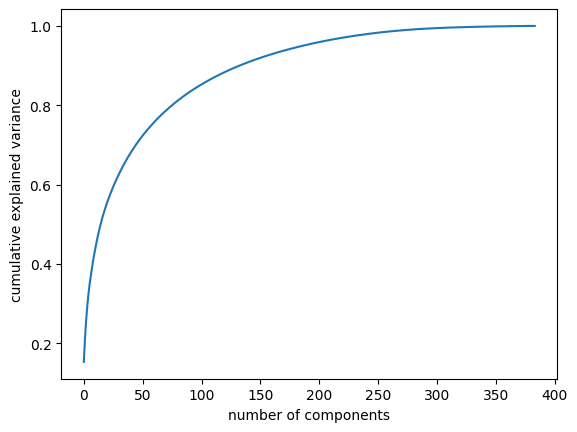

In [87]:
# do PCA to reduce the dimension of the embedding
from sklearn.decomposition import PCA
# draw the scree plot to find the best number of components
pca = PCA().fit(embeddings_mean['review_embedding'].tolist())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [102]:
# calculate the norm embedding of each business
embeddings_mean['norm'] = embeddings_mean['review_embedding'].apply(lambda x: np.linalg.norm(x))
embeddings_mean.head()

,business_id,review_embedding,norm
0,--OS_I7dnABrXvRCCuWOGQ,"[-0.065532655, 0.04373445, 0.10778973, -0.0569...",0.781180
1,--sXnWH9Xm6_NvIjyuA99w,"[0.049394462, 0.008136967, 0.048414223, 0.0140...",0.666610
2,-0M0b-XhtFagyLmsBtOe8w,"[0.060161255, -0.021785468, 0.010562328, 0.041...",0.904549
3,-0TffRSXXIlBYVbb5AwfTg,"[-0.0055325706, -0.0027510356, 0.033008873, 0....",0.705663
4,-0eUa8TsXFFy0FCxHYmrjg,"[-0.020555913, 0.016941091, 0.05686598, 0.0132...",0.684946


In [103]:
# merge the mean of each dimension of the embedding with the business
business_embedding = business.merge(embeddings_mean, left_on='business_id', right_on='business_id', how='left')

In [104]:
business_embedding.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,OBJECTID,review_embedding,norm
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107.0,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",272.0,"[0.017745266, 0.027339203, 0.058737658, 0.0381...",0.697132
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106.0,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",272.0,"[-0.015232248, 0.018101547, 0.05400468, 0.0410...",0.725347
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147.0,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",180.0,"[0.012701459, 0.025426373, 0.03280707, 0.03357...",0.696932
3,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147.0,39.939825,-75.157447,4.0,65,0,"{'Smoking': ""u'no'"", 'NoiseLevel': ""u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",180.0,"[-0.0035258902, 0.0019610194, 0.02884522, 0.02...",0.662978
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,4105 Main St,Philadelphia,PA,19127.0,40.022466,-75.218314,3.0,41,0,"{'RestaurantsReservations': 'False', 'Caters':...","Pizza, Restaurants, Salad, Soup","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-1...",100.0,"[0.0075855865, 0.009780679, 0.030568298, 0.057...",0.683931


In [200]:
# calculate the mean of each OBJECTID of the embedding
business_embedding_mean = business_embedding.groupby('OBJECTID')
business_embedding_mean = business_embedding_mean['review_embedding'].mean()
business_embedding_mean = pd.DataFrame(business_embedding_mean)
business_embedding_mean.reset_index(level=0, inplace=True)
business_embedding_mean['OBJECTID'] = business_embedding_mean['OBJECTID'].astype('int64')
# sum  of each dim
business_embedding_mean['sum'] = business_embedding_mean['review_embedding'].apply(lambda x: np.sum(x))
business_embedding_mean.head()

,OBJECTID,review_embedding,sum
0,1,"[-0.0072971657, 0.027892847, 0.043126047, 0.02...",-0.186188
1,2,"[-0.016091036, 0.011508807, 0.03022512, 0.0220...",-0.175365
2,3,"[-0.017094212, 0.019894611, 0.046038613, 0.019...",-0.255384
3,4,"[-0.00036392122, -0.004292042, 0.056085248, 0....",-0.183019
4,5,"[-0.005497571, 0.014580106, 0.036960825, 0.015...",-0.259990


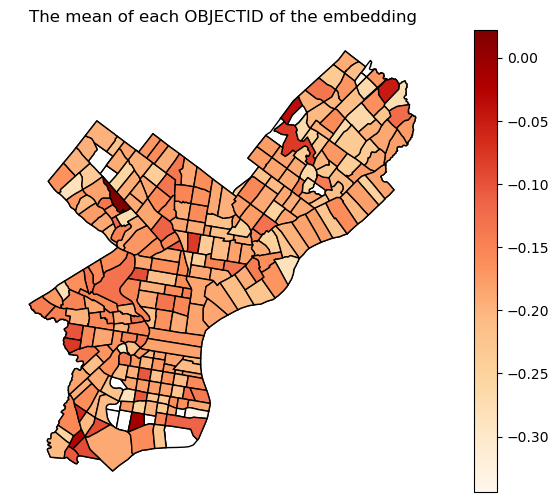

In [ ]:
# plot
Business_embedding_distribution = Boundary.merge(business_embedding_mean, left_on='OBJECTID', right_on='OBJECTID', how='left')
fig, ax = plt.subplots(1, figsize=(10, 6))
Boundary.plot(ax=ax, color='white', edgecolor='black')
Business_embedding_distribution.plot(ax=ax, column='sum', cmap='OrRd', edgecolor='black', legend=True)
ax.set_title('The mean of each OBJECTID of the embedding')
ax.set_axis_off()
plt.show()

### Area whole embeddings

In [230]:
area_review_embedding = pd.read_csv('../data/PA/review_Phi_area_embedding.csv')

In [232]:
area_review_embedding['text_embedding'] = area_review_embedding['text_embedding'].apply(str2vec)
area_review_embedding.head()

,OBJECTID,text,text_embedding
0,1.0,I'm from Cali but the breakfast here was fanta...,"[-0.07674567, -0.0008003752, 0.07075666, 0.030..."
1,2.0,I went to the store this week after having my ...,"[-0.073701896, 0.013854215, 0.012131911, 0.019..."
2,3.0,My wife and I along with close friends had a f...,"[-0.0011630371, 0.06096341, 0.1484326, 0.07913..."
3,4.0,By far the best massage I've ever had. I try ...,"[-0.045970555, -0.001202208, 0.065767944, 0.02..."
4,5.0,Upon walking into this place I wasn't sure if ...,"[0.031630203, 0.014539911, 0.06407039, 0.05415..."


### OpenAI embeddings

In [252]:
# read npy file
poi_embeddings = np.load('../data/PA/poi_embeddings.npy')

In [256]:
poi_embeddings = pd.DataFrame(poi_embeddings)

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,-0.006852,0.008814,0.000569,-0.013993,-0.017298,0.005592,0.028013,-0.007224,-0.032888,-0.016265,...,0.025451,-0.002961,0.022600,0.011975,-0.035312,0.020796,-0.032420,0.009792,-0.014667,-0.025093
1,-0.014156,-0.016827,-0.000455,-0.009675,-0.025025,-0.004720,0.001438,-0.006179,-0.017243,-0.029977,...,0.016089,0.027306,0.010527,-0.011667,-0.032929,0.012244,-0.003804,0.008970,-0.024650,-0.038001
2,0.008924,-0.005784,0.008031,-0.016529,-0.027534,-0.000923,0.020884,-0.010964,-0.006822,-0.019414,...,0.012331,0.028798,0.016955,-0.009700,-0.023564,0.025748,-0.015004,-0.012414,-0.032755,-0.032206
3,0.001950,-0.004120,-0.002840,-0.002131,-0.019651,0.014235,0.013691,-0.008744,-0.002553,-0.027381,...,0.000672,0.015585,0.031750,-0.021538,-0.016633,0.022903,-0.021607,-0.016853,-0.012147,-0.033486
4,-0.012341,-0.005623,0.008024,-0.013713,-0.023781,0.009278,0.004102,-0.016810,-0.020330,-0.029075,...,0.002396,0.006586,0.030766,-0.015618,-0.021286,0.017295,-0.032844,-0.002571,-0.022949,-0.034369


In [257]:
business_poi = pd.read_csv('../data/yelp_dataset-2/business_Phi_info.csv')
poi_embeddings['business_id'] = business_poi['business_id']

In [258]:
poi_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,business_id
0,-0.006852,0.008814,0.000569,-0.013993,-0.017298,0.005592,0.028013,-0.007224,-0.032888,-0.016265,...,-0.002961,0.022600,0.011975,-0.035312,0.020796,-0.032420,0.009792,-0.014667,-0.025093,--OS_I7dnABrXvRCCuWOGQ
1,-0.014156,-0.016827,-0.000455,-0.009675,-0.025025,-0.004720,0.001438,-0.006179,-0.017243,-0.029977,...,0.027306,0.010527,-0.011667,-0.032929,0.012244,-0.003804,0.008970,-0.024650,-0.038001,--sXnWH9Xm6_NvIjyuA99w
2,0.008924,-0.005784,0.008031,-0.016529,-0.027534,-0.000923,0.020884,-0.010964,-0.006822,-0.019414,...,0.028798,0.016955,-0.009700,-0.023564,0.025748,-0.015004,-0.012414,-0.032755,-0.032206,-0M0b-XhtFagyLmsBtOe8w
3,0.001950,-0.004120,-0.002840,-0.002131,-0.019651,0.014235,0.013691,-0.008744,-0.002553,-0.027381,...,0.015585,0.031750,-0.021538,-0.016633,0.022903,-0.021607,-0.016853,-0.012147,-0.033486,-0TffRSXXIlBYVbb5AwfTg
4,-0.012341,-0.005623,0.008024,-0.013713,-0.023781,0.009278,0.004102,-0.016810,-0.020330,-0.029075,...,0.006586,0.030766,-0.015618,-0.021286,0.017295,-0.032844,-0.002571,-0.022949,-0.034369,-0eUa8TsXFFy0FCxHYmrjg


In [259]:
# get the OBJECTID from the business dataframe, combine with the poi_embeddings
business_obj = business[['business_id', 'OBJECTID']]
poi_embeddings = poi_embeddings.merge(business_obj, left_on='business_id', right_on='business_id', how='left')
poi_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,1528,1529,1530,1531,1532,1533,1534,1535,business_id,OBJECTID
0,-0.006852,0.008814,0.000569,-0.013993,-0.017298,0.005592,0.028013,-0.007224,-0.032888,-0.016265,...,0.022600,0.011975,-0.035312,0.020796,-0.032420,0.009792,-0.014667,-0.025093,--OS_I7dnABrXvRCCuWOGQ,76.0
1,-0.014156,-0.016827,-0.000455,-0.009675,-0.025025,-0.004720,0.001438,-0.006179,-0.017243,-0.029977,...,0.010527,-0.011667,-0.032929,0.012244,-0.003804,0.008970,-0.024650,-0.038001,--sXnWH9Xm6_NvIjyuA99w,272.0
2,0.008924,-0.005784,0.008031,-0.016529,-0.027534,-0.000923,0.020884,-0.010964,-0.006822,-0.019414,...,0.016955,-0.009700,-0.023564,0.025748,-0.015004,-0.012414,-0.032755,-0.032206,-0M0b-XhtFagyLmsBtOe8w,260.0
3,0.001950,-0.004120,-0.002840,-0.002131,-0.019651,0.014235,0.013691,-0.008744,-0.002553,-0.027381,...,0.031750,-0.021538,-0.016633,0.022903,-0.021607,-0.016853,-0.012147,-0.033486,-0TffRSXXIlBYVbb5AwfTg,278.0
4,-0.012341,-0.005623,0.008024,-0.013713,-0.023781,0.009278,0.004102,-0.016810,-0.020330,-0.029075,...,0.030766,-0.015618,-0.021286,0.017295,-0.032844,-0.002571,-0.022949,-0.034369,-0eUa8TsXFFy0FCxHYmrjg,277.0


In [265]:
# calculate the mean of each OBJECTID of the embedding
poi_embeddings_mean = poi_embeddings.groupby('OBJECTID')
poi_embeddings_mean = poi_embeddings_mean[poi_embeddings.columns[0:1535]].mean()
poi_embeddings_mean = pd.DataFrame(poi_embeddings_mean)
poi_embeddings_mean.reset_index(level=0, inplace=True)
poi_embeddings_mean['OBJECTID'] = poi_embeddings_mean['OBJECTID'].astype('int64')
poi_embeddings_mean.head()

,OBJECTID,0,1,2,3,4,5,6,7,8,...,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534
0,1,-0.004231,-0.011109,-0.001519,-0.022304,-0.019136,0.003019,0.010735,-0.019546,-0.006230,...,0.023018,-0.000025,-0.000393,0.021671,-0.010203,-0.016535,0.015006,-0.027509,-0.009214,-0.012466
1,2,-0.009465,-0.009218,0.003220,-0.025324,-0.021671,0.009897,0.004110,-0.015299,-0.009953,...,0.023177,0.000918,-0.002329,0.026395,-0.010033,-0.019757,0.015941,-0.022577,-0.007926,-0.009287
2,3,-0.008067,-0.007782,0.007791,-0.017316,-0.019999,0.006628,0.011159,-0.033721,-0.015346,...,0.013332,0.014251,-0.003277,0.022618,-0.006346,-0.024457,0.017062,-0.023190,-0.014458,-0.003738
3,4,-0.007273,-0.009504,0.010899,-0.020260,-0.019582,0.003674,0.003728,-0.015393,-0.013954,...,0.011662,0.003636,0.002944,0.023506,-0.011391,-0.022483,0.013939,-0.024927,-0.013622,-0.000380
4,5,-0.004138,-0.003350,0.007419,-0.021328,-0.021466,0.008399,0.011077,-0.019690,-0.010356,...,0.015038,0.007659,0.000330,0.025158,-0.011988,-0.021418,0.016861,-0.020167,-0.004425,-0.008362


In [268]:
poi_demand = demand[['OBJECTID','mean']]
poi_demand = poi_demand.merge(poi_embeddings_mean, left_on='OBJECTID', right_on='OBJECTID', how='left')

In [269]:
poi_demand

,OBJECTID,mean,0,1,2,3,4,5,6,7,...,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534
0,123.0,447.333333,-0.006104,-0.023649,-0.002316,-0.010399,-0.019611,0.018906,-0.000275,-0.011760,...,0.008003,0.002918,-0.011696,0.021832,-0.005115,-0.020419,0.014120,-0.018007,0.006823,-0.022452
1,125.0,251.833333,-0.006406,-0.001904,0.000973,-0.021522,-0.021366,0.007008,0.008835,-0.017575,...,0.018089,0.007354,0.001884,0.020020,-0.008323,-0.022028,0.021881,-0.025972,-0.010586,-0.014618
2,129.0,1518.750000,-0.007074,-0.007060,0.003333,-0.022288,-0.020785,0.007568,0.006079,-0.019983,...,0.014283,0.007214,0.001474,0.023652,-0.010290,-0.022640,0.019684,-0.020210,-0.009763,-0.010038
3,131.0,3926.875000,-0.007806,-0.013581,0.003829,-0.013832,-0.026817,0.015597,0.005176,-0.018896,...,0.011260,0.000255,0.006848,0.014427,-0.013163,-0.026502,0.016562,-0.010905,-0.006505,-0.015157
4,133.0,532.958333,-0.004770,-0.003617,-0.000100,-0.027396,-0.015810,0.015938,0.009851,-0.021624,...,0.009043,0.001193,0.001102,0.021139,-0.011485,-0.015957,0.017970,-0.008728,-0.009302,-0.014030
5,135.0,2135.916667,-0.006140,-0.013498,0.001332,-0.021180,-0.020958,0.000105,0.002344,-0.026607,...,0.021517,0.001801,-0.001668,0.026883,-0.010782,-0.018490,0.020175,-0.024505,-0.009486,-0.007777
6,136.0,626.958333,-0.001815,-0.012894,0.002887,-0.025344,-0.024819,0.008947,0.009263,-0.021433,...,0.015694,0.003735,-0.000847,0.026893,-0.016381,-0.018769,0.022852,-0.020610,-0.008765,-0.012759
7,137.0,2247.416667,-0.003202,-0.010897,0.002549,-0.026225,-0.019706,0.008453,0.009991,-0.020149,...,0.014620,0.002854,0.005048,0.022475,-0.010569,-0.019968,0.023431,-0.020051,-0.007052,-0.007552
8,139.0,242.541667,-0.008113,-0.008509,0.002513,-0.024548,-0.019326,0.009045,0.008441,-0.020457,...,0.015011,0.003534,-0.003950,0.027761,-0.011347,-0.022322,0.017816,-0.018409,-0.007422,-0.011183
9,141.0,3655.125000,-0.003690,-0.010968,-0.000037,-0.021307,-0.020290,0.003566,0.008506,-0.021132,...,0.019908,0.001997,0.001150,0.027247,-0.012594,-0.020366,0.015160,-0.024323,-0.008367,-0.007269


## Quarter Bike Demand

In [211]:
demand = pd.read_csv('../data/PA/share_bike/demand2019to2022.csv')
demand['review_embedding'] = demand['review_embedding'].apply(str2vec)

In [233]:
# drop the first column
demand = demand.merge(area_review_embedding, left_on='demand_index', right_on='OBJECTID', how='left')
demand.head()

,2019_q1_start_count,2019_q1_end_count,2019_q2_start_count,2019_q2_end_count,2019_q3_start_count,2019_q3_end_count,2019_q4_start_count,2019_q4_end_count,2020_q1_start_count,2020_q1_end_count,...,2022_q4_start_count,2022_q4_end_count,demand_index,mean,review_embedding,sum,business_count,OBJECTID,text,text_embedding
0,51,47,606,546,689,688,195,179,199,168,...,152,145,123,447.333333,"[0.06605022, 0.0068315966, 0.08827199, 0.00187...",-0.097948,2,123.0,The Dell Music Center is a very nice venue to ...,"[0.051628705, -0.0049998197, 0.052494783, 0.04..."
1,122,126,992,987,1029,1021,358,349,216,241,...,193,209,125,251.833333,"[-0.021743586, 0.018160429, 0.048676968, 0.026...",-0.213921,10,125.0,I really miss great breakfast & diners the cit...,"[-0.009906397, 0.026443781, 0.14209083, -0.010..."
2,396,460,1053,1170,1766,1818,855,865,593,650,...,1287,1462,129,1518.750000,"[-0.008930559, 0.0045045, 0.04460491, 0.015985...",-0.184746,106,129.0,Love this place! We went because it was walkin...,"[-0.012601582, -0.039664738, 0.09234433, 0.024..."
3,1499,1462,5443,5343,4911,4886,1752,1795,1473,1510,...,1729,1636,131,3926.875000,"[0.0314853, 0.037486065, 0.052541416, 0.028685...",-0.151672,26,131.0,We came back again this year and they had a gr...,"[0.062621005, 0.02809563, 0.038865216, 0.06554..."
4,218,172,961,890,741,676,209,149,195,139,...,477,446,133,532.958333,"[-0.02485271, 0.028962314, 0.05134198, -0.0010...",-0.194643,10,133.0,The only reason I'm even giving this company o...,"[-0.1043298, 0.035737883, 0.0875851, -0.033897..."


In [127]:
review_dim = business_embedding_mean[['review_embedding']]
# transform the review_embedding to a 384 dimension vector
review_dim = review_dim['review_embedding'].apply(pd.Series)
review_dim['OBJECTID'] = business_embedding_mean['OBJECTID']
review_dim.to_csv('../data/PA/review_mean_vector.csv')

In [246]:
area_review_dim = demand[['text_embedding']]
area_review_dim = area_review_dim['text_embedding'].apply(pd.Series)
area_review_dim.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.051629,-0.005000,0.052495,0.043209,-0.047624,0.008287,-0.005237,-0.013814,0.009670,0.014541,...,0.016072,0.002724,-0.004276,0.125628,0.043703,0.026485,-0.033523,-0.066975,-0.080083,0.047777
1,-0.009906,0.026444,0.142091,-0.010820,-0.067166,-0.004514,0.019971,-0.060610,-0.001336,-0.106535,...,-0.025140,-0.033653,-0.003187,-0.066016,0.087408,0.002279,-0.009331,0.060884,-0.034580,0.009011
2,-0.012602,-0.039665,0.092344,0.024462,-0.034399,0.064934,0.009656,-0.040974,0.025246,0.013804,...,0.052158,-0.039850,-0.083599,-0.005023,0.056950,0.061441,-0.004452,-0.042207,-0.077449,0.003629
3,0.062621,0.028096,0.038865,0.065541,0.018270,-0.006732,-0.030626,0.043834,-0.043573,0.070355,...,0.040978,-0.032030,0.014641,-0.109459,0.028541,0.001465,0.100284,-0.144294,-0.076677,0.022442
4,-0.104330,0.035738,0.087585,-0.033897,-0.012241,-0.007848,0.044742,-0.024267,-0.083347,-0.058697,...,-0.010362,-0.082202,-0.033360,0.030863,0.016274,0.045201,-0.049282,-0.022070,-0.030997,-0.007379


In [136]:
review_dim_trip = demand[['review_embedding']]
# transform the review_embedding to a 384 dimension vector
review_dim_trip = review_dim_trip['review_embedding'].apply(pd.Series)
review_dim_trip.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.066050,0.006832,0.088272,0.001871,-0.001361,0.017789,-0.000011,-0.043736,-0.049160,0.007641,...,0.053805,0.003349,0.010486,0.038908,0.015463,0.011285,0.007632,0.000987,-0.085983,0.016094
1,-0.021744,0.018160,0.048677,0.026562,-0.067783,-0.020417,-0.010637,-0.042312,-0.015333,-0.051123,...,0.015001,-0.007475,0.007448,-0.034687,0.034963,0.038500,-0.009439,-0.003022,-0.049692,0.034434
2,-0.008931,0.004504,0.044605,0.015985,-0.040091,-0.013886,-0.002711,-0.028781,-0.016427,-0.035898,...,0.013369,-0.005803,-0.006195,-0.019044,0.020681,0.032314,-0.000311,-0.019684,-0.060571,0.023170
3,0.031485,0.037486,0.052541,0.028686,-0.011761,0.006808,-0.025124,-0.036545,-0.039353,-0.007638,...,0.050168,0.006489,-0.013098,-0.028720,0.005843,0.008963,0.013099,-0.004200,-0.079342,0.031424
4,-0.024853,0.028962,0.051342,-0.001097,-0.021145,-0.027899,0.001764,-0.019226,-0.024781,-0.031193,...,0.006507,-0.008414,0.008204,-0.036638,0.032762,0.036218,-0.012390,-0.027384,-0.043982,0.020800


In [141]:
# get the mean demand of each quarter
demand_mean = demand[['2020_q1_start_count', '2020_q1_end_count', '2020_q2_start_count', '2020_q2_end_count', '2020_q3_start_count', '2020_q3_end_count', '2020_q4_start_count', '2020_q4_end_count', '2021_q1_start_count', '2021_q1_end_count', '2021_q2_start_count', '2021_q2_end_count', '2021_q3_start_count', '2021_q3_end_count', '2021_q4_start_count', '2021_q4_end_count', '2022_q1_start_count', '2022_q1_end_count', '2022_q2_start_count', '2022_q2_end_count', '2022_q3_start_count', '2022_q3_end_count', '2022_q4_start_count', '2022_q4_end_count']]
demand_mean['Quarter_demand'] = demand_mean.apply(lambda x: x.mean(), axis=1)
# drop the original demand columns
demand_mean = demand_mean.drop(['2020_q1_start_count', '2020_q1_end_count', '2020_q2_start_count', '2020_q2_end_count', '2020_q3_start_count', '2020_q3_end_count', '2020_q4_start_count', '2020_q4_end_count', '2021_q1_start_count', '2021_q1_end_count', '2021_q2_start_count', '2021_q2_end_count', '2021_q3_start_count', '2021_q3_end_count', '2021_q4_start_count', '2021_q4_end_count', '2022_q1_start_count', '2022_q1_end_count', '2022_q2_start_count', '2022_q2_end_count', '2022_q3_start_count', '2022_q3_end_count', '2022_q4_start_count', '2022_q4_end_count'], axis=1)
# merge review_dim_trip to demand_mean
demand_mean = demand_mean.merge(review_dim_trip,left_index=True,right_index=True)
demand_mean.to_csv('../data/PA/demand_mean.csv')

/var/folders/tw/gz2w91cj3fj4x6fqjsqpt1m80000gn/T/ipykernel_17286/3232139272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_mean['Quarter_demand'] = demand_mean.apply(lambda x: x.mean(), axis=1)


In [163]:
demand['mean'] = demand_mean['Quarter_demand']

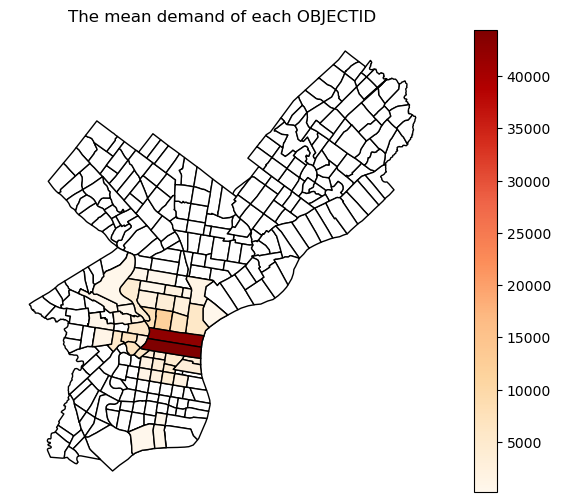

In [165]:
# plot the mean demand of each OBJECTID
Demand_distribution = Boundary.merge(demand, left_on='OBJECTID', right_on='demand_index', how='left')
fig, ax = plt.subplots(1, figsize=(10, 6))
Boundary.plot(ax=ax, color='white', edgecolor='black')
Demand_distribution.plot(ax=ax, column='mean', cmap='OrRd', edgecolor='black', legend=True)
ax.set_title('The mean demand of each OBJECTID')
ax.set_axis_off()
plt.show()

In [166]:
demand_mean.head()

,Quarter_demand,0,1,2,3,4,5,6,7,8,...,374,375,376,377,378,379,380,381,382,383
0,447.333333,0.066050,0.006832,0.088272,0.001871,-0.001361,0.017789,-0.000011,-0.043736,-0.049160,...,0.053805,0.003349,0.010486,0.038908,0.015463,0.011285,0.007632,0.000987,-0.085983,0.016094
1,251.833333,-0.021744,0.018160,0.048677,0.026562,-0.067783,-0.020417,-0.010637,-0.042312,-0.015333,...,0.015001,-0.007475,0.007448,-0.034687,0.034963,0.038500,-0.009439,-0.003022,-0.049692,0.034434
2,1518.750000,-0.008931,0.004504,0.044605,0.015985,-0.040091,-0.013886,-0.002711,-0.028781,-0.016427,...,0.013369,-0.005803,-0.006195,-0.019044,0.020681,0.032314,-0.000311,-0.019684,-0.060571,0.023170
3,3926.875000,0.031485,0.037486,0.052541,0.028686,-0.011761,0.006808,-0.025124,-0.036545,-0.039353,...,0.050168,0.006489,-0.013098,-0.028720,0.005843,0.008963,0.013099,-0.004200,-0.079342,0.031424
4,532.958333,-0.024853,0.028962,0.051342,-0.001097,-0.021145,-0.027899,0.001764,-0.019226,-0.024781,...,0.006507,-0.008414,0.008204,-0.036638,0.032762,0.036218,-0.012390,-0.027384,-0.043982,0.020800


array([[<Axes: title={'center': 'Quarter_demand'}>]], dtype=object)

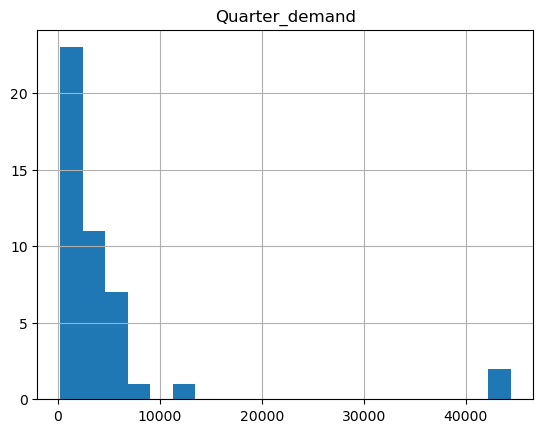

In [176]:
# hist the mean demand
demand_mean.hist(column='Quarter_demand', bins=20)

## Simple Models to predict the demand

In [183]:
# do linear regression to predict the mean demand
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# X is the columns of the demand_mean 1-384
X = demand_mean.iloc[:, 1:385]
# y is the mean demand
y = demand_mean.iloc[:, 0]
# Normalize the y data
y = (y - y.mean()) / y.std()
# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))


Mean squared error: 5.48
Coefficient of determination: -1.57


In [177]:
# apply Random Forest to predict the mean demand
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 2.82
Coefficient of determination: -0.32


In [178]:
# apply other mechine learning models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 2.42
Coefficient of determination: -0.14


In [247]:
# use area review embedding
X_area = area_review_dim
X_area.columns = X_area.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_area, y, test_size=0.2, random_state=42)

In [249]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 2.45
Coefficient of determination: -0.15


In [250]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 2.41
Coefficient of determination: -0.13


In [251]:
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 2.69
Coefficient of determination: -0.26


### add business numbers as a feature

In [240]:
# only use the business number to predict the mean demand
X = demand['business_count'].astype('int64')
X = pd.DataFrame(X)
y = demand_mean.iloc[:, 0]
# Normalize the y data
y = (y - y.mean()) / y.std()
# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 0.11
Coefficient of determination: 0.95


#### use mean review embedding

In [217]:
#  add embeddings to the model
X = demand_mean.iloc[:, 1:385]
X['business_count'] = demand['business_count'].astype('int64')
X.columns = X.columns.astype(str)
y = demand_mean.iloc[:, 0]
# Normalize the y data
y = (y - y.mean()) / y.std()
# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# linear regression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 0.33
Coefficient of determination: 0.84


In [ ]:
# apply Random Forest to predict the mean demand
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 1.67
Coefficient of determination: 0.21


In [ ]:
# apply Gradient Boosting to predict the mean demand
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 0.95
Coefficient of determination: 0.55


#### use area review embeddings

In [236]:
# use area review embedding
X_area = area_review_dim
X_area['business_count'] = demand['business_count'].astype('int64')
X_area.columns = X_area.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_area, y, test_size=0.2, random_state=42)

In [237]:
# linear regression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 0.11
Coefficient of determination: 0.95


In [238]:
# apply Random Forest to predict the mean demand
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 1.77
Coefficient of determination: 0.17


In [239]:
# apply Gradient Boosting to predict the mean demand
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 1.37
Coefficient of determination: 0.36


## use the OpenAI embeddings

In [270]:
X = poi_demand.iloc[:, 2:1537]
# y is the mean demand
y = poi_demand.iloc[:, 1]
# Normalize the y data
y = (y - y.mean()) / y.std()
# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 3.61
Coefficient of determination: -0.70


In [271]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 3.31
Coefficient of determination: -0.56


In [272]:
# apply Gradient Boosting to predict the mean demand
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 5.27
Coefficient of determination: -1.48


### add business numbers as a feature

In [273]:
X['business_count'] = demand['business_count'].astype('int64')
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [274]:
# linear regression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 0.20
Coefficient of determination: 0.91


In [276]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 2.48
Coefficient of determination: -0.16


In [277]:
# apply Gradient Boosting to predict the mean demand
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))

Mean squared error: 4.57
Coefficient of determination: -1.15


## Analyze the Employee Earnings

In [157]:
earnings = pd.read_csv("../data/PA/employee_earnings.csv")
salaries_arc = pd.read_csv("../data/PA/employee_salaries_archive.csv")

In [158]:
earnings.head()

,calendar_year,quarter,last_name,first_name,title,job_code,department_name,department_number,base_salary,salary_type,...,base_gross_pay_qtd,longevity_gross_pay_qtd,post_separation_gross_pay_qtd,miscellaneous_gross_pay_qtd,employee_category,compulsory_union_code,termination_month,termination_year,public_id,objectid
0,2021,4,Coleman,Carl,Heavy Equipment Operator 2,7C14,PWD Water,28,51731.0,Salaried,...,15212.48,905.92,NaN,603.29,Civil Service,M,NaN,NaN,27049,932268
1,2020,4,Joyner,Charlene,Police Officer 1,6A02,PPD Police,11,78092.0,Salaried,...,20944.70,3072.60,NaN,2557.69,Civil Service,P,NaN,NaN,16507,932269
2,2021,2,Joyner,Charlene,Police Officer 1,6A02,PPD Police,11,78092.0,Salaried,...,17952.60,2824.58,NaN,2351.24,Civil Service,P,NaN,NaN,16507,932270
3,2021,1,Mullin,Lisa,Social Work Services Manager 2,5A07,DHS Dept of Human Services,22,65712.0,Salaried,...,15157.15,386.68,NaN,0.00,Civil Service,J,NaN,NaN,6969,932271
4,2020,3,Isaac,Deatrice,Deputy Commissioner,D250,PRO Procurement,38,117600.0,Salaried,...,31629.88,NaN,NaN,0.00,Exempt,E,NaN,NaN,13301,932272


In [152]:
salaries_arc.head()

,objectid,calendar_year,quarter,last_name,first_name,title,department,annual_salary,ytd_overtime_gross
0,1,2016,1,CHILIBERTI,ROSEMARY,ADM TECHNICIAN III,COMMON PLEAS COURT,50543.0,0.0
1,2,2016,1,SMITH,KARI,SENIOR CREW CHIEF,MANAGING DIRECTOR'S OFFICE,34842.0,0.0
2,3,2016,1,BRUMSKILL,SANDRA,SCHOOL CROSSING GUARD,POLICE DEPARTMENT,0.0,0.0
3,4,2016,1,ALEXANDER,KHADEJAH,CLERK TEMPORARY-SUMMER-$7.00/HR.,COMMON PLEAS COURT,0.0,0.0
4,5,2016,1,HILL,SEAN,PROBATION OFFICER 2,COMMON PLEAS COURT,56206.0,0.0


In [149]:
len(earnings)

466084

In [9]:
earnings['the_geom'].isna().sum()

466084